In [1]:
%matplotlib inline

# Imports
import gc
import matplotlib
matplotlib.rc('font',family='Times', size=8)
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion
import sklearn.pipeline

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Setup PLOS ONE font dictionary
plos_one_fontdict = {'fontname': "Serif", 'fontsize': 8}

In [3]:
# Read model output
raw_data = pandas.read_csv("../data/output/raw_docket_justice_model_growing_random_forest_5.csv.gz", compression="gzip", low_memory=False)
case_data = pandas.read_csv("../data/output/raw_docket_case_model_growing_random_forest_5.csv.gz", compression="gzip", low_memory=False, index_col="docketId")
feature_importance_df = pandas.read_csv("../data/output/raw_docket_features_model_growing_random_forest_5.csv.gz", compression="gzip", low_memory=False)

## Reversal Rate by Decade

In [4]:
# Get decade average
case_data.loc[:, "term_decade"] = (case_data["term"] / 10).astype(int) * 10.0
decade_reverse_rate = case_data.groupby("term_decade")["case_outcome_reverse"].mean()

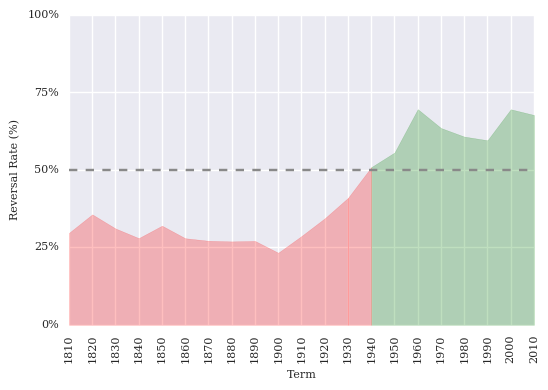

In [5]:
# Setup grid
f = plt.figure(figsize=(6, 4), dpi=400)
ax = plt.gca()

# Handle justice accuracy
ax_id = 0
column_name = "Reversal Rate by Decade"

# Setup title and data
#ax.set_title("{0}".format(column_name), fontsize=10)
ts_data = decade_reverse_rate
min_term = int(ts_data.index.min())
max_term = int(ts_data.index.max())
min_val = 0.0
max_val = 1.0

# Plot fill and marker
ax.axhline(0.5, linestyle='--', color='#898989') # horizontal lines
ax.fill_between(ts_data.index, 0, ts_data, where=(ts_data >= 0.5), alpha=0.25, color="green", interpolate=False)
ax.fill_between(ts_data.index, 0, ts_data, where=(ts_data <= 0.5), alpha=0.25, color="red", interpolate=False)
ax.fill_between(ts_data.loc[[1930,1940]].index, 0, ts_data.loc[[1930,1940]], alpha=0.25, color="red", interpolate=False)

# Setup axes ranges
decade_range = numpy.arange(min_term, max_term, 10)
decade_range = numpy.append(decade_range, 2010)
reverse_range = numpy.round(numpy.linspace(min_val, max_val, 5), 4)

# Set on axis
_ = ax.set_xlim(min_term, max_term)
_ = ax.set_xticks(decade_range)
_ = ax.set_xticklabels(map(str, decade_range), fontdict=plos_one_fontdict, rotation=90)
_ = ax.set_ylim(min_val, max_val)
_ = ax.set_yticks(reverse_range)
_ = ax.set_yticklabels(map(lambda x: "{0}%".format(int(x * 100)), reverse_range), fontdict=plos_one_fontdict)

# Set axis label
_ = ax.set_xlabel("Term", fontdict=plos_one_fontdict)
_ = ax.set_ylabel("Reversal Rate (%)", fontdict=plos_one_fontdict)

# Save as PNG, PDF, and SVG
plt.savefig("../figures/decade_reversal_rate.png", dpi=400)
plt.savefig("../figures/decade_reversal_rate.tif", dpi=400)
plt.savefig("../figures/decade_reversal_rate.pdf", dpi=400)
plt.savefig("../figures/decade_reversal_rate.svg")

### Justice Confusion Matrix - Other/Affirm/Reverse

In [6]:
# Evaluation range
term_range = raw_data.loc[~raw_data.loc[:, "rf_predicted"].isnull(), "term"].unique()
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)

# Compare model
print("RF model")
print("="*32)
justice_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual, target_predicted), columns=["Other", "Affirm", "Reverse"], index=["Other", "Affirm", "Reverse"])
justice_confusion_df

RF model


,Other,Affirm,Reverse
Other,23275,11825,4440
Affirm,2900,89989,20777
Reverse,1649,46824,45096


In [7]:
print(justice_confusion_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Other &  Affirm &  Reverse \\
\midrule
Other   &  23275 &   11825 &     4440 \\
Affirm  &   2900 &   89989 &    20777 \\
Reverse &   1649 &   46824 &    45096 \\
\bottomrule
\end{tabular}



In [8]:
# Evaluation range
term_range = raw_data.loc[~raw_data.loc[:, "rf_predicted"].isnull(), "term"].unique()
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual_reverse = ((raw_data.loc[evaluation_index, "justice_outcome_disposition"]) > 0).astype(int)
target_predicted_reverse = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
target_dummy_reverse = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)

# Compare model
print("RF model")
print("="*32)
justice_reverse_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(target_actual_reverse, target_predicted_reverse), columns=["Not Reverse", "Reverse"], index=["Not Reverse", "Reverse"])
justice_reverse_confusion_df

RF model


,Not Reverse,Reverse
Not Reverse,127989,25217
Reverse,48473,45096


In [9]:
print(justice_reverse_confusion_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Not Reverse &  Reverse \\
\midrule
Not Reverse &       127989 &    25217 \\
Reverse     &        48473 &    45096 \\
\bottomrule
\end{tabular}



### Case Confusion Matrix

In [10]:
case_data.head()

,rf_predicted_reverse,dummy_predicted_reverse,case_outcome_reverse,term,naturalCourt,rf_correct_case,dummy_correct_case,docketId.1,term_decade
docketId,,,,,,,,,
1816-001-01,1,0,0,1816,406,0,1,1816-001-01,1810.0
1816-002-01,0,0,0,1816,406,1,1,1816-002-01,1810.0
1816-003-01,0,0,0,1816,406,1,1,1816-003-01,1810.0
1816-004-01,1,0,0,1816,406,0,1,1816-004-01,1810.0
1816-005-01,0,0,0,1816,406,1,1,1816-005-01,1810.0


In [11]:
# Setup case vectors
case_target_actual = case_data.loc[:, "case_outcome_reverse"]
case_target_predicted = case_data.loc[:, "rf_predicted_reverse"]

# Compare model
print("RF model")
print("="*32)
case_confusion_df = pandas.DataFrame(sklearn.metrics.confusion_matrix(case_target_actual, case_target_predicted), columns=["Affirm", "Reverse"], index=["Affirm", "Reverse"])
case_confusion_df

RF model


,Affirm,Reverse
Affirm,13967,2773
Reverse,5663,5677


In [12]:
print(case_confusion_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Affirm &  Reverse \\
\midrule
Affirm  &   13967 &     2773 \\
Reverse &    5663 &     5677 \\
\bottomrule
\end{tabular}



### Feature Importance Time Series

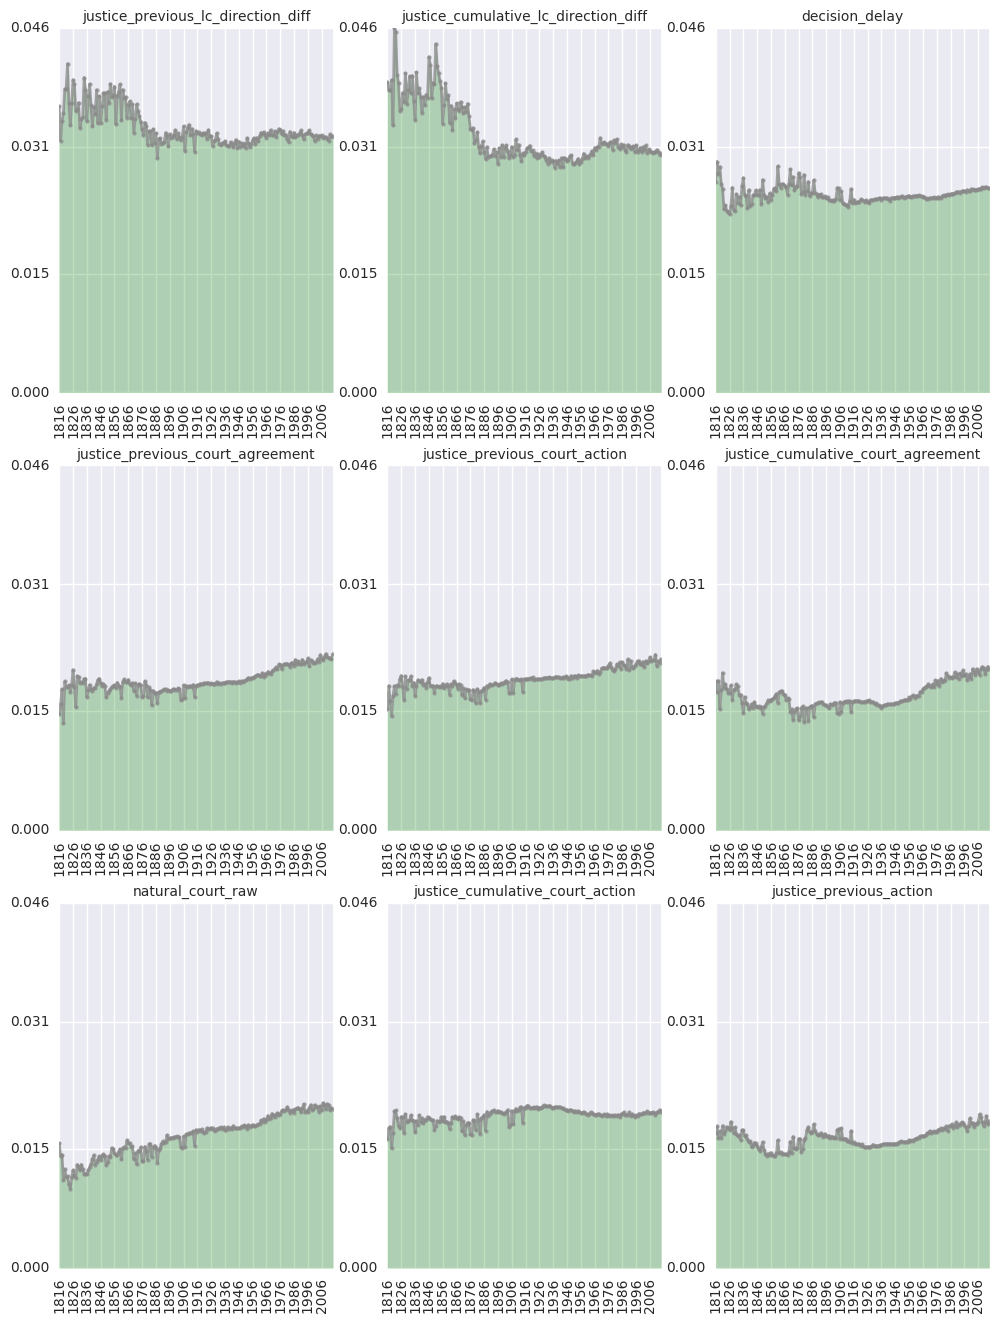

In [13]:
# Setup feature importance TS
feature_importance_ts = feature_importance_df.groupby(["term", "feature"])["importance"].mean().unstack()

# Get last step weights
num_feature_rows = 3
num_feature_cols = 3
num_feature_total = num_feature_rows * num_feature_cols
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(12,16))

for i in range(len(last_step_top_features)):
    # Get iteration indices
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    feature_name = last_step_top_features[i]
    
    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(feature_name), fontsize=10)
    ts_data = feature_importance_ts.loc[:, feature_name]
    
    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)
    
    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

In [14]:
# Setup colormap for all positive-negative heatmaps
red_green_cmap = seaborn.diverging_palette(h_neg=10, h_pos=135, as_cmap=True)

### Justice Accuracy Heatmap - Other/Affirm/Reverse

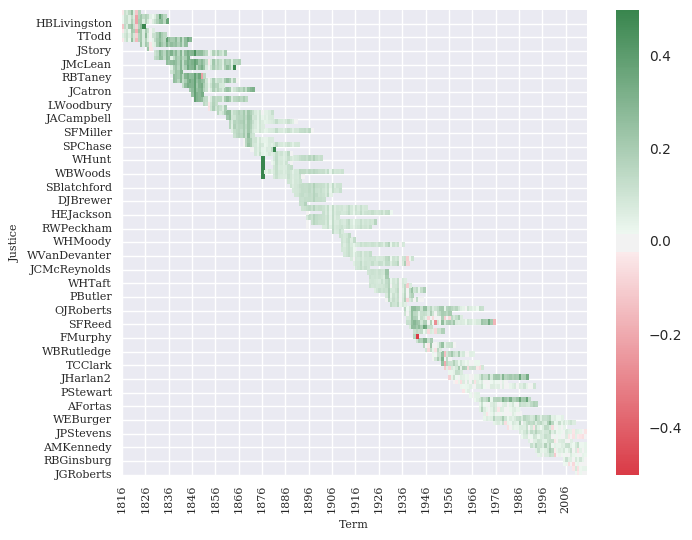

In [15]:
# Setup grouping over evaluation index
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & ~raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()

if '-99' in justice_order:
    justice_order.remove('-99')
    
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]

# Setup grid
f = plt.figure(figsize=(7.5, 6), dpi=400)
ax = plt.gca()
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup term labels
term_label_index = numpy.arange(0, max_term - min_term, 10)
term_labels = [term_range[i] for i in term_label_index]
_ = ax.set_xticks(term_label_index)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

# Setup Justice labels
justice_label_index = numpy.arange(0, len(justice_order), 3)
justice_labels = list(reversed([justice_order[i] for i in justice_label_index]))

_ = ax.set_yticks(justice_label_index)
_ = ax.set_yticklabels(justice_labels, fontdict=plos_one_fontdict)

# Axis label
_ = ax.set_xlabel("Term", fontdict=plos_one_fontdict)
_ = ax.set_ylabel("Justice", fontdict=plos_one_fontdict)

# Draw grid
ax.grid()

# Save as PNG, PDF, and SVG
plt.savefig("../figures/justice_accuracy_heatmap.png", dpi=400)
plt.savefig("../figures/justice_accuracy_heatmap.tif", dpi=400)
plt.savefig("../figures/justice_accuracy_heatmap.pdf", dpi=400)
plt.savefig("../figures/justice_accuracy_heatmap.svg")

### Justice Accuracy Heatmap - Reverse/Not-Reverse

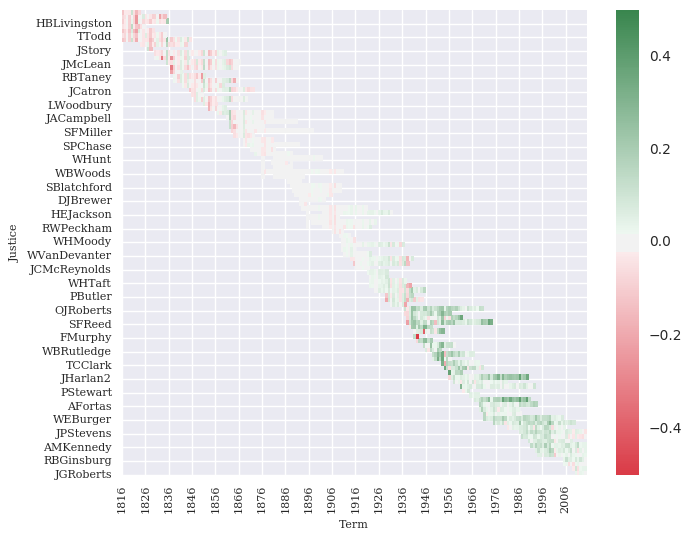

In [16]:
# Setup grouping over evaluation index
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & ~raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()

if '-99' in justice_order:
    justice_order.remove('-99')
    
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_reverse_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_reverse_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]

# Setup grid
f = plt.figure(figsize=(7.5, 6), dpi=400)
ax = plt.gca()
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup term labels
term_label_index = numpy.arange(0, max_term - min_term, 10)
term_labels = [term_range[i] for i in term_label_index]
_ = ax.set_xticks(term_label_index)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

# Setup Justice labels
justice_label_index = numpy.arange(0, len(justice_order), 3)
justice_labels = list(reversed([justice_order[i] for i in justice_label_index]))

_ = ax.set_yticks(justice_label_index)
_ = ax.set_yticklabels(justice_labels, fontdict=plos_one_fontdict,)

# Axis label
_ = ax.set_xlabel("Term", fontdict=plos_one_fontdict)
_ = ax.set_ylabel("Justice", fontdict=plos_one_fontdict)

# Draw grid
ax.grid()

# Save as PNG, PDF, and SVG
plt.savefig("../figures/justice_reverse_accuracy_heatmap.png", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_heatmap.tif", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_heatmap.pdf", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_heatmap.svg")

### Justice Accuracy Heatmap - Recent Court

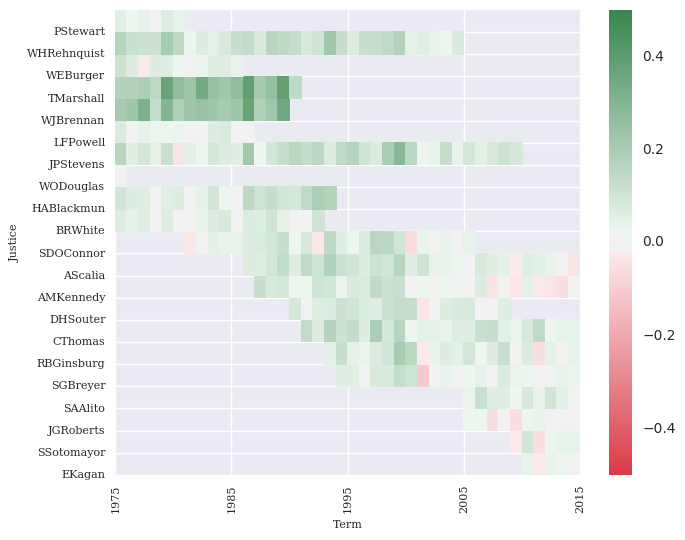

In [17]:
# Setup grouping over evaluation index
evaluation_index = raw_data.loc[:, "term"].isin(range(1975, 2016)) & ~raw_data.loc[:, "case_outcome_disposition"].isnull()
justice_order = raw_data.loc[evaluation_index, :].groupby(["justiceName"])["term"].min().sort_values().index.tolist()

if '-99' in justice_order:
    justice_order.remove('-99')
    
justice_accuracy_ts = raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["rf_reverse_correct"].mean().unstack() - \
    raw_data.loc[evaluation_index, :].groupby(["term", "justiceName"])["dummy_reverse_correct"].mean().unstack()
min_term = min(justice_accuracy_ts.index)
max_term = max(justice_accuracy_ts.index)
    
# Setup plot
num_justices = justice_accuracy_ts.shape[1]
num_years = justice_accuracy_ts.shape[0]

# Setup grid
f = plt.figure(figsize=(7.5, 6), dpi=400)
ax = plt.gca()
seaborn.heatmap(justice_accuracy_ts.loc[:, justice_order].T, vmin=-0.5, vmax=0.5, ax=ax, cmap=red_green_cmap)

# Setup term labels
term_label_index = numpy.arange(0, 2016 - min_term, 10)
term_labels = [range(min_term, 2016)[i] for i in term_label_index]
_ = ax.set_xticks(term_label_index)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

# Setup Justice labels
justice_label_index = numpy.arange(0, len(justice_order), 1)
justice_labels = list(reversed([justice_order[i] for i in justice_label_index]))

_ = ax.set_yticks(justice_label_index)
_ = ax.set_yticklabels(justice_labels, fontdict=plos_one_fontdict,)

# Axis label
_ = ax.set_xlabel("Term", fontdict=plos_one_fontdict)
_ = ax.set_ylabel("Justice", fontdict=plos_one_fontdict)

# Draw grid
ax.grid()

# Save as PNG, PDF, and SVG
plt.savefig("../figures/justice_reverse_accuracy_recent_heatmap.png", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_recent_heatmap.tif", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_recent_heatmap.pdf", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_recent_heatmap.svg")

### Performance by Vote Configuration

In [18]:
# Get reverse/affirm by case
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & ~raw_data.loc[:, "case_outcome_disposition"].isnull()
reverse_per_case = raw_data.loc[evaluation_index, :].groupby("docketId")["justice_outcome_reverse"].sum()
total_per_case = raw_data.loc[evaluation_index, :].groupby("docketId")["justice_outcome_reverse"].count()
affirm_per_case = total_per_case - reverse_per_case

# Set onto case data
case_data.loc[:, "reverse_votes"] = reverse_per_case.astype(int)
case_data.loc[:, "affirm_votes"] = affirm_per_case.astype(int)

In [19]:
# Build outcome string list
outcome_string_list = []

for row_id, row in case_data.iterrows():
    try:
        if row["reverse_votes"] > row["affirm_votes"]:
            outcome_string = "{0}-{1} R".format(int(row["reverse_votes"]), int(row["affirm_votes"]))
        else:
            outcome_string = "{0}-{1} A".format(int(row["affirm_votes"]), int(row["reverse_votes"]))
    except ValueError as e:
        outcome_string = None
        
    outcome_string_list.append(outcome_string)

# Set outcomes
case_data.loc[:, "outcome_configuration"] = outcome_string_list

In [20]:
case_data.head().T

docketId,1816-001-01,1816-002-01,1816-003-01,1816-004-01,1816-005-01
rf_predicted_reverse,1,0,0,1,0
dummy_predicted_reverse,0,0,0,0,0
case_outcome_reverse,0,0,0,0,0
term,1816,1816,1816,1816,1816
naturalCourt,406,406,406,406,406
rf_correct_case,0,1,1,0,1
dummy_correct_case,1,1,1,1,1
docketId.1,1816-001-01,1816-002-01,1816-003-01,1816-004-01,1816-005-01
term_decade,1810,1810,1810,1810,1810
reverse_votes,0,0,0,0,0


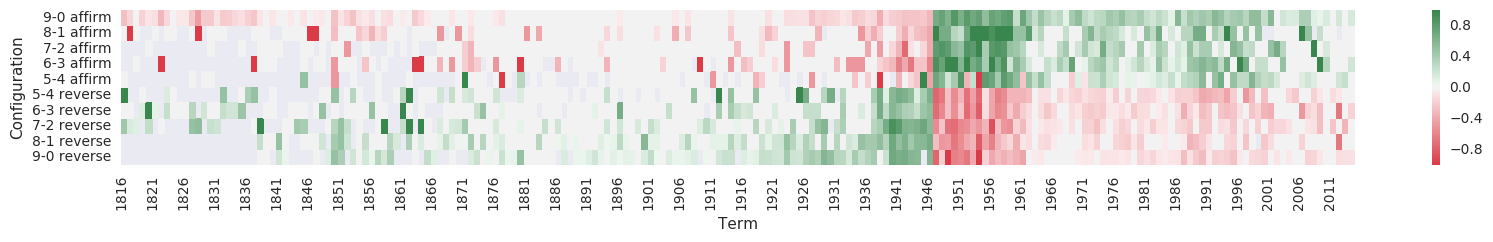

In [22]:
# Setup configuration data
configuration_list = ['9-0 affirm', '8-1 affirm', '7-2 affirm', '6-3 affirm', '5-4 affirm', '5-4 reverse', '6-3 reverse', '7-2 reverse', '8-1 reverse', '9-0 reverse']
case_config_ts = case_data.groupby(["term", "reverse_votes"])["rf_correct_case"].mean().unstack() -\
    case_data.groupby(["term", "reverse_votes"])["dummy_correct_case"].mean().unstack()
del case_config_ts[10.0]
case_config_ts.columns = configuration_list
min_term = min(case_config_ts.index)
max_term = max(case_config_ts.index)

# Setup plot
num_configs = case_config_ts.shape[1]
num_years = case_config_ts.shape[0]
f, ax = plt.subplots(figsize=(num_years / 10, num_configs / 5))
seaborn.heatmap(case_config_ts.loc[:, configuration_list].T, cmap=red_green_cmap)

# Setup labels
_ = ax.set_xticks(numpy.arange(0, max_term - min_term, 5))
_ = ax.set_xticklabels(map(str, numpy.arange(min_term, max_term, 5)), rotation=90)
ax.set_xlabel("Term")
ax.set_ylabel("Configuration")

### Raw Model Accuracy Time Series

In [23]:
# Load all raw data frames
raw_data_always_reverse = pandas.read_csv("../data/output/raw_docket_justice_baseline_model_always_reverse.csv.gz", compression="gzip", low_memory=False)
raw_data_most_frequent_10 = pandas.read_csv("../data/output/raw_docket_justice_baseline_model_most_frequent_10.csv.gz", compression="gzip", low_memory=False)
raw_data_most_frequent_20 = pandas.read_csv("../data/output/raw_docket_justice_baseline_model_most_frequent_20.csv.gz", compression="gzip", low_memory=False)
raw_data_most_frequent_infinite = pandas.read_csv("../data/output/raw_docket_justice_baseline_model_most_frequent_infinite.csv.gz", compression="gzip", low_memory=False)


In [46]:
# Justice accuracy by model type
justice_accuracy_reverse_rf = raw_data.groupby("term")["rf_reverse_correct"].mean()
justice_accuracy_reverse_always_reverse = raw_data_always_reverse.groupby("term")["baseline_reverse_correct"].mean()
justice_accuracy_reverse_most_frequent_10 = raw_data_most_frequent_10.groupby("term")["baseline_reverse_correct"].mean()
justice_accuracy_reverse_most_frequent_20 = raw_data_most_frequent_20.groupby("term")["baseline_reverse_correct"].mean()
justice_accuracy_reverse_most_frequent_infinite = raw_data_most_frequent_infinite.groupby("term")["baseline_reverse_correct"].mean()

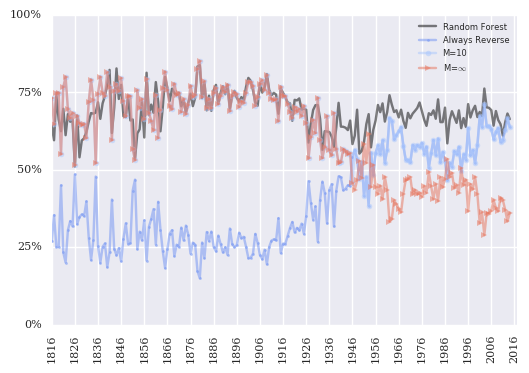

In [48]:
# Plot on one plot
f, ax = plt.subplots(figsize=(6, 4), dpi=400)

# Palette
pal = seaborn.color_palette("coolwarm", 5)

# Plot model
_ = ax.plot(justice_accuracy_reverse_rf.index, justice_accuracy_reverse_rf, 
            alpha=0.5, marker="x", markersize=4, color="black")
_ = ax.plot(justice_accuracy_reverse_always_reverse.index, justice_accuracy_reverse_always_reverse, 
            alpha=0.5, marker=".", markersize=4, color=pal[0])
_ = ax.plot(justice_accuracy_reverse_most_frequent_10.index, justice_accuracy_reverse_most_frequent_10, 
            alpha=0.5, marker="o", markersize=4, color=pal[1])
#_ = ax.plot(justice_accuracy_reverse_most_frequent_20.index, justice_accuracy_reverse_most_frequent_20, 
#            alpha=0.5, marker="<", markersize=4, color=pal[3])
_ = ax.plot(justice_accuracy_reverse_most_frequent_infinite.index, justice_accuracy_reverse_most_frequent_infinite, 
            alpha=0.5, marker=">", markersize=4, color=pal[4])

# Setup axes
term_labels = numpy.arange(min_term, max_term+3, 10)
_ = ax.set_xlim(min_term, max_term+3)
_ = ax.set_xticks(term_labels)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

min_val=0.0
max_val=1.0
accuracy_labels = numpy.round(numpy.linspace(min_val, max_val, 5), 4)
_ = ax.set_ylim(min_val, max_val)
_ = ax.set_yticks(accuracy_labels)
_ = ax.set_yticklabels(map(lambda x: "{0}%".format(int(x * 100)), accuracy_labels), fontdict=plos_one_fontdict)

ax.legend(("Random Forest", "Always Reverse", "M=10", 
           #"M=20",
           "M=$\infty$"), loc='best', fontsize=6)

# Save as PNG, PDF, and SVG
plt.savefig("../figures/justice_reverse_accuracy_comparison_ts.png", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_comparison_ts.tif", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_comparison_ts.pdf", dpi=400)
plt.savefig("../figures/justice_reverse_accuracy_comparison_ts.svg")

In [26]:
# Get all case accuracy TS
raw_data.loc[:, "justice_outcome_disposition_reverse"] = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
case_accuracy_reverse_rf = (raw_data.groupby("docketId")["rf_predicted_reverse"].mean() > 0.5) == (raw_data.groupby("docketId")["justice_outcome_disposition_reverse"].mean() > 0.5)
case_accuracy_reverse_always_reverse = (raw_data_always_reverse.groupby("docketId")["baseline_predicted_reverse"].mean() > 0.5) == (raw_data_always_reverse.groupby("docketId")["justice_outcome_disposition_reverse"].mean() > 0.5)
case_accuracy_reverse_most_frequent_10 = (raw_data_most_frequent_10.groupby("docketId")["baseline_predicted_reverse"].mean() > 0.5) == (raw_data_most_frequent_10.groupby("docketId")["justice_outcome_disposition_reverse"].mean() > 0.5)
case_accuracy_reverse_most_frequent_20 = (raw_data_most_frequent_20.groupby("docketId")["baseline_predicted_reverse"].mean() > 0.5) == (raw_data_most_frequent_20.groupby("docketId")["justice_outcome_disposition_reverse"].mean() > 0.5)
case_accuracy_reverse_most_frequent_infinite = (raw_data_most_frequent_infinite.groupby("docketId")["baseline_predicted_reverse"].mean() > 0.5) == (raw_data_most_frequent_infinite.groupby("docketId")["justice_outcome_disposition_reverse"].mean() > 0.5)

In [27]:
# Set names
case_accuracy_reverse_rf.name = "case_accuracy_reverse_rf"
case_accuracy_reverse_always_reverse.name = "case_accuracy_reverse_always_reverse"
case_accuracy_reverse_most_frequent_10.name = "case_accuracy_reverse_most_frequent_10"
case_accuracy_reverse_most_frequent_20.name = "case_accuracy_reverse_most_frequent_20"
case_accuracy_reverse_most_frequent_infinite.name = "case_accuracy_reverse_most_frequent_infinite"

if "case_accuracy_reverse_rf" not in case_data.columns:
    # Set into case data
    case_data = case_data.join(case_accuracy_reverse_rf.astype(int))\
        .join(case_accuracy_reverse_always_reverse.astype(int))\
        .join(case_accuracy_reverse_most_frequent_10.astype(int))\
        .join(case_accuracy_reverse_most_frequent_20.astype(int))\
        .join(case_accuracy_reverse_most_frequent_infinite.astype(int))

# Group by
case_accuracy_reverse_rf_ts = case_data.groupby("term")["case_accuracy_reverse_rf"].mean()
case_accuracy_reverse_always_reverse_ts = case_data.groupby("term")["case_accuracy_reverse_always_reverse"].mean()
case_accuracy_reverse_most_frequent_10_ts = case_data.groupby("term")["case_accuracy_reverse_most_frequent_10"].mean()
case_accuracy_reverse_most_frequent_20_ts = case_data.groupby("term")["case_accuracy_reverse_most_frequent_20"].mean()
case_accuracy_reverse_most_frequent_infinite_ts = case_data.groupby("term")["case_accuracy_reverse_most_frequent_infinite"].mean()

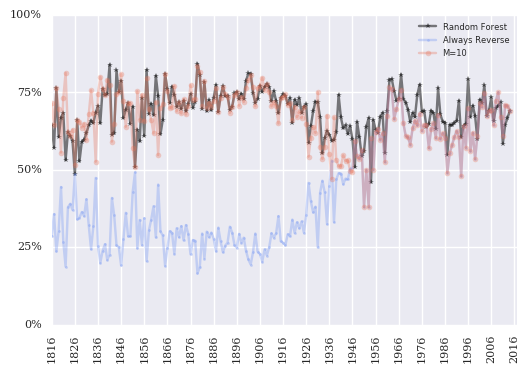

In [49]:
# Plot on one plot
f, ax = plt.subplots(figsize=(6, 4), dpi=400)

# Palette
pal = seaborn.color_palette("coolwarm", 5)

# Plot model
_ = ax.plot(case_accuracy_reverse_rf_ts.index, case_accuracy_reverse_rf_ts,
            alpha=0.5, marker="*", markersize=4, color="black")
_ = ax.plot(case_accuracy_reverse_always_reverse_ts.index, case_accuracy_reverse_always_reverse_ts, 
            alpha=0.33, marker=".", markersize=4, color=pal[0])
_ = ax.plot(case_accuracy_reverse_most_frequent_10_ts.index, case_accuracy_reverse_most_frequent_10_ts, 
            alpha=0.33, marker="o", markersize=4, color=pal[4])
# = ax.plot(case_accuracy_reverse_most_frequent_20_ts.index, case_accuracy_reverse_most_frequent_20_ts, 
#           alpha=0.5, marker="<", markersize=4, color=pal[3])
# = ax.plot(case_accuracy_reverse_most_frequent_infinite_ts.index, case_accuracy_reverse_most_frequent_infinite_ts, 
#           alpha=0.5, marker=">", markersize=4, color=pal[4])

# Setup axes
term_labels = numpy.arange(min_term, max_term+3, 10)
_ = ax.set_xlim(min_term, max_term+3)
_ = ax.set_xticks(term_labels)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

accuracy_labels = numpy.round(numpy.linspace(min_val, max_val, 5), 4)
_ = ax.set_ylim(min_val, max_val)
_ = ax.set_yticks(accuracy_labels)
_ = ax.set_yticklabels(map(lambda x: "{0}%".format(int(x * 100)), accuracy_labels), fontdict=plos_one_fontdict)

ax.legend(("Random Forest", "Always Reverse", "M=10",
           #M=20",
           #M=$\infty$"
          ), loc='best', fontsize=6)

# Save as PNG, PDF, and SVG
plt.savefig("../figures/case_reverse_accuracy_comparison_ts.png", dpi=400)
plt.savefig("../figures/case_reverse_accuracy_comparison_ts.tif", dpi=400)
plt.savefig("../figures/case_reverse_accuracy_comparison_ts.pdf", dpi=400)
plt.savefig("../figures/case_reverse_accuracy_comparison_ts.svg")

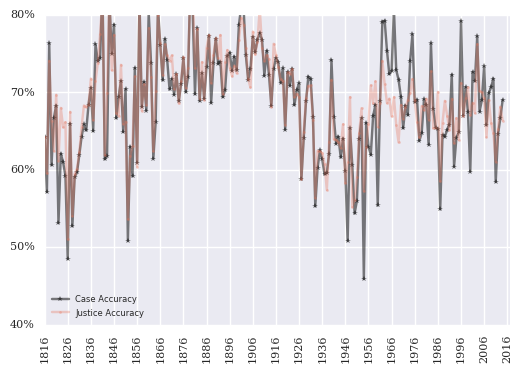

In [29]:
# Plot on one plot
f, ax = plt.subplots(figsize=(6, 4), dpi=400)

# Palette
pal = seaborn.color_palette("coolwarm", 5)

# Plot model
_ = ax.plot(case_accuracy_reverse_rf_ts.index, case_accuracy_reverse_rf_ts,
            alpha=0.5, marker="*", markersize=4, color="black")

_ = ax.plot(justice_accuracy_reverse_rf.index, justice_accuracy_reverse_rf, 
            alpha=0.33, marker=".", markersize=4, color=pal[4])


# Setup axes
term_labels = numpy.arange(min_term, max_term+3, 10)
_ = ax.set_xlim(min_term, max_term+3)
_ = ax.set_xticks(term_labels)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)


accuracy_labels = numpy.round(numpy.linspace(0.4, 0.8, 5), 4)
_ = ax.set_ylim(0.4, 0.8)
_ = ax.set_yticks(accuracy_labels)
_ = ax.set_yticklabels(map(lambda x: "{0}%".format(int(x * 100)), accuracy_labels), fontdict=plos_one_fontdict)

ax.legend(("Case Accuracy", "Justice Accuracy",
           #M=20",
           #M=$\infty$"
          ), loc='best', fontsize=6)


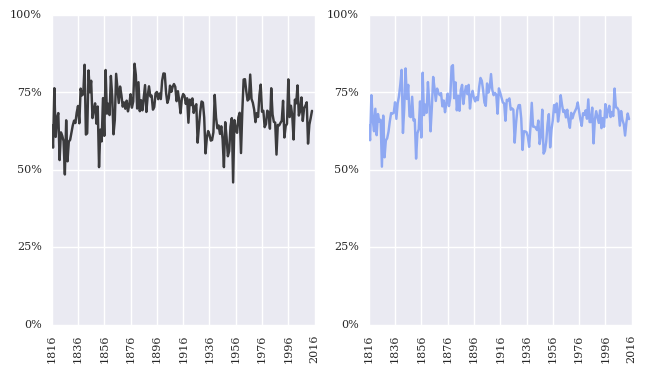

In [50]:
# Plot on one plot
f, ax = plt.subplots(1, 2, figsize=(7.5, 4), dpi=400)

# Palette
pal = seaborn.color_palette("coolwarm", 5)

# Plot model
_ = ax[0].plot(case_accuracy_reverse_rf_ts.index, case_accuracy_reverse_rf_ts,
            alpha=0.75, color="black")

_ = ax[1].plot(justice_accuracy_reverse_rf.index, justice_accuracy_reverse_rf, 
            alpha=0.75, color=pal[0])

# Setup axes
term_labels = numpy.arange(min_term, max_term+3, 20)
_ = ax[0].set_xlim(min_term, max_term+3)
_ = ax[1].set_xlim(min_term, max_term+3)
_ = ax[0].set_xticks(term_labels)
_ = ax[1].set_xticks(term_labels)
_ = ax[0].set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)
_ = ax[1].set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

accuracy_labels = numpy.round(numpy.linspace(min_val, max_val, 5), 4)
_ = ax[0].set_ylim(min_val, max_val)
_ = ax[0].set_yticks(accuracy_labels)
_ = ax[0].set_yticklabels(map(lambda x: "{0}%".format(int(x * 100)), accuracy_labels), fontdict=plos_one_fontdict)
_ = ax[1].set_ylim(min_val, max_val)
_ = ax[1].set_yticks(accuracy_labels)
_ = ax[1].set_yticklabels(map(lambda x: "{0}%".format(int(x * 100)), accuracy_labels), fontdict=plos_one_fontdict)


# Save as PNG, PDF, and SVG
plt.savefig("../figures/reverse_accuracy_rf_ts.png", dpi=400)
plt.savefig("../figures/reverse_accuracy_rf_ts.tif", dpi=400)
plt.savefig("../figures/reverse_accuracy_rf_ts.pdf", dpi=400)
plt.savefig("../figures/reverse_accuracy_rf_ts.svg")

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()


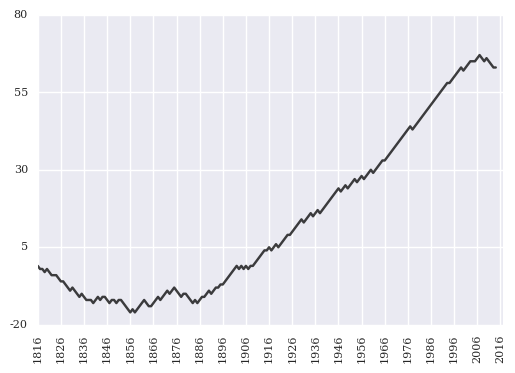

In [43]:
# Setup time series
case_evaluation_index = ~case_data.loc[:, "rf_correct_case"].isnull()
rf_correct_case_ts = case_data.loc[case_evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = case_data.loc[case_evaluation_index, :].groupby("term")["dummy_correct_case"].mean()
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f, ax = plt.subplots(figsize=(6, 4), dpi=400)
ax.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts, color="black",
        alpha=0.75)

# Setup axes
term_labels = numpy.arange(min_term, max_term+3, 10)
_ = ax.set_xlim(min_term, max_term+3)
_ = ax.set_xticks(term_labels)
_ = ax.set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)

accuracy_labels = numpy.round(numpy.linspace(-20, 80, 5), 4)
_ = ax.set_ylim(-20, 80)
_ = ax.set_yticks(accuracy_labels)
_ = ax.set_yticklabels(map(lambda x: "{0}".format(int(x)), accuracy_labels), fontdict=plos_one_fontdict)

# Save as PNG, PDF, and SVG
plt.savefig("../figures/cumulative_terms_won_lost.png", dpi=400)
plt.savefig("../figures/cumulative_terms_won_lost.tif", dpi=400)
plt.savefig("../figures/cumulative_terms_won_lost.pdf", dpi=400)
plt.savefig("../figures/cumulative_terms_won_lost.svg")

[]

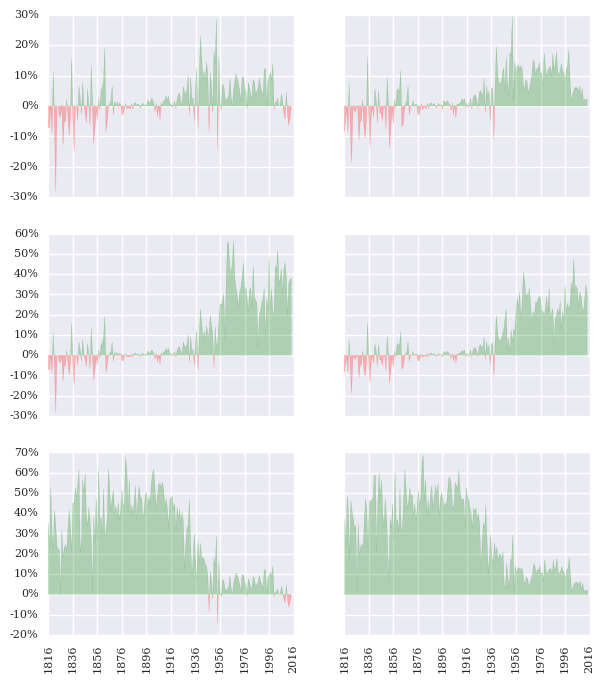

In [79]:
# Setup grid
f, ax = plt.subplots(3, 2, figsize=(7,8))

# Setup axes
term_labels = numpy.arange(min_term, max_term+3, 20)

# Plot justice M=10
row_1_labels = [-.3, -.2, -.1, 0, .1, .2, .3]
case_spread_against_m10 = case_accuracy_reverse_rf_ts - case_accuracy_reverse_most_frequent_10_ts
ax[0, 0].fill_between(case_spread_against_m10.index, 0, case_spread_against_m10,
                      where=(case_spread_against_m10 >= 0), alpha=0.25, color="green", interpolate=True)
ax[0, 0].fill_between(case_spread_against_m10.index, 0, case_spread_against_m10,
                      where=(case_spread_against_m10 < 0), alpha=0.25, color="red", interpolate=True)
ax[0, 0].set_xlim(min_term, max_term+3)
ax[0, 0].set_xticks(term_labels)
ax[0, 0].set_xticklabels([])
ax[0, 0].set_ylim(-0.3, 0.3)
ax[0, 0].set_yticks(row_1_labels)
ax[0, 0].set_yticklabels(map(lambda x: "{0}%".format(int(100 * x)), row_1_labels), fontdict=plos_one_fontdict)

# Plot justice M=10
justice_spread_against_m10 = justice_accuracy_reverse_rf - justice_accuracy_reverse_most_frequent_10
ax[0, 1].fill_between(justice_spread_against_m10.index, 0, justice_spread_against_m10,
                      where=(justice_spread_against_m10 >= 0), alpha=0.25, color="green", interpolate=True)
ax[0, 1].fill_between(justice_spread_against_m10.index, 0, justice_spread_against_m10,
                      where=(justice_spread_against_m10 < 0), alpha=0.25, color="red", interpolate=True)
ax[0, 1].set_xlim(min_term, max_term+3)
ax[0, 1].set_xticks(term_labels)
ax[0, 1].set_xticklabels([])
ax[0, 1].set_ylim(-0.3, 0.3)
ax[0, 1].set_yticks(row_1_labels)
ax[0, 1].set_yticklabels([])


# Plot justice M=infinite
row_2_labels = [-.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6]
case_spread_against_minf = case_accuracy_reverse_rf_ts - case_accuracy_reverse_most_frequent_infinite_ts
ax[1, 0].fill_between(case_spread_against_minf.index, 0, case_spread_against_minf,
                      where=(case_spread_against_minf >= 0), alpha=0.25, color="green", interpolate=True)
ax[1, 0].fill_between(case_spread_against_minf.index, 0, case_spread_against_minf,
                      where=(case_spread_against_minf < 0), alpha=0.25, color="red", interpolate=True)
ax[1, 0].set_xlim(min_term, max_term+3)
ax[1, 0].set_xticks(term_labels)
ax[1, 0].set_xticklabels([])
ax[1, 0].set_ylim(-0.3, 0.6)
ax[1, 0].set_yticks(row_2_labels)
ax[1, 0].set_yticklabels(map(lambda x: "{0}%".format(int(100 * x)), row_2_labels), fontdict=plos_one_fontdict)


# Plot justice M=infinite
justice_spread_against_minf = justice_accuracy_reverse_rf - justice_accuracy_reverse_most_frequent_infinite
ax[1, 1].fill_between(justice_spread_against_minf.index, 0, justice_spread_against_minf,
                      where=(justice_spread_against_minf >= 0), alpha=0.25, color="green", interpolate=True)
ax[1, 1].fill_between(justice_spread_against_minf.index, 0, justice_spread_against_minf,
                      where=(justice_spread_against_minf < 0), alpha=0.25, color="red", interpolate=True)
ax[1, 1].set_xlim(min_term, max_term+3)
ax[1, 1].set_xticks(term_labels)
ax[1, 1].set_xticklabels([])
ax[1, 1].set_ylim(-0.3, 0.6)
ax[1, 1].set_yticks(row_2_labels)
ax[1, 1].set_yticklabels([])


# Plot justice always reverse
row_3_labels = [-.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7]
case_spread_against_ar = case_accuracy_reverse_rf_ts - case_accuracy_reverse_always_reverse_ts
ax[2, 0].fill_between(case_spread_against_ar.index, 0, case_spread_against_ar,
                      where=(case_spread_against_ar >= 0), alpha=0.25, color="green", interpolate=True)
ax[2, 0].fill_between(case_spread_against_ar.index, 0, case_spread_against_ar,
                      where=(case_spread_against_ar < 0), alpha=0.25, color="red", interpolate=True)
ax[2, 0].set_xlim(min_term, max_term+3)
ax[2, 0].set_xticks(term_labels)
ax[2, 0].set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)
ax[2, 0].set_ylim(-0.2, 0.7)
ax[2, 0].set_yticks(row_3_labels)
ax[2, 0].set_yticklabels(map(lambda x: "{0}%".format(int(100 * x)), row_3_labels), fontdict=plos_one_fontdict)

# Plot justice always reverse
justice_spread_against_ar = justice_accuracy_reverse_rf - justice_accuracy_reverse_always_reverse
ax[2, 1].fill_between(justice_spread_against_ar.index, 0, justice_spread_against_ar,
                      where=(justice_spread_against_ar >= 0), alpha=0.25, color="green", interpolate=True)
ax[2, 1].fill_between(justice_spread_against_ar.index, 0, justice_spread_against_ar,
                      where=(justice_spread_against_ar < 0), alpha=0.25, color="red", interpolate=True)
ax[2, 1].set_xlim(min_term, max_term+3)
ax[2, 1].set_xticks(term_labels)
ax[2, 1].set_xticklabels(map(str, term_labels), fontdict=plos_one_fontdict, rotation=90)
ax[2, 1].set_ylim(-0.2, 0.7)
ax[2, 1].set_yticks(row_3_labels)
ax[2, 1].set_yticklabels([])

# Save as PNG, PDF, and SVG
plt.savefig("../figures/baseline_accuracy_compari.png", dpi=400)
plt.savefig("../figures/cumulative_terms_won_lost.tif", dpi=400)
plt.savefig("../figures/cumulative_terms_won_lost.pdf", dpi=400)
plt.savefig("../figures/cumulative_terms_won_lost.svg")